### Query SDSS stripe 82 database for multiple observations of same object, make cutouts and co-add, display all together with JPEG cutout.
Thanks to Ani Thakar for SQL

In [13]:
import SciServer.CasJobs
import pandas
import tables
import numpy as np
import astropy
from astropy.io import fits
from astropy import wcs
import skimage.io
import urllib
import os

%config InlineBackend.rc = {}
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rc_file("matplotlibrc")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [14]:
sql="""
SELECT a.objid as head, c.objid2 as match, b.matchcount, 
       p.fieldid as head_field, d.fieldid as match_field, 
       dbo.fGetUrlFitsCFrame(d.fieldid, 'g') as fits_g,
       dbo.fGetUrlFitsCFrame(d.fieldid, 'r') as fits_r,
       dbo.fGetUrlFitsCFrame(d.fieldid, 'z') as fits_z,
       p.ra, d.ra as match_ra, p.dec, d.dec as match_dec
       , p.petror90_r
  from (select top 1 * from galaxy where objId=8658194378960928809) a
      -- dbo.fGetNearbyObjEq(309.33, -1.08, 0.1) a
   join matchhead b on a.objid=b.objid        -- join with matchhead
   join photoobj p on a.objid=p.objid         -- get matchhead photoobj
   join match c on c.objid1=b.objid           -- join with all the matches
   join photoobjall d on c.objid2=d.objid     -- get match photoobj
order by a.objid                              -- order by matchhead objid
"""
#queryResponse = SciServer.CasJobs.executeQuery(sql, "Stripe82")#,token=token)
#obss = pandas.read_csv(queryResponse,index_col=None)
obss = SciServer.CasJobs.executeQuery(sql, "Stripe82")
obss

,head,match,matchcount,head_field,match_field,fits_g,fits_r,fits_z,ra,match_ra,dec,match_dec,petror90_r
0,8658194378960928809,8658194430499553320,57,8658194378960928768,8658194430499553280,http://das.sdss.org/imaging/5622/40/corr/1/fpC...,http://das.sdss.org/imaging/5622/40/corr/1/fpC...,http://das.sdss.org/imaging/5622/40/corr/1/fpC...,18.876797,18.876842,-0.860931,-0.860955,45.09392
1,8658194378960928809,8658194477742948377,57,8658194378960928768,8658194477742948352,http://das.sdss.org/imaging/5633/40/corr/1/fpC...,http://das.sdss.org/imaging/5633/40/corr/1/fpC...,http://das.sdss.org/imaging/5633/40/corr/1/fpC...,18.876797,18.876855,-0.860931,-0.860959,45.09392
2,8658194378960928809,8658194516375371821,57,8658194378960928768,8658194516375371776,http://das.sdss.org/imaging/5642/40/corr/1/fpC...,http://das.sdss.org/imaging/5642/40/corr/1/fpC...,http://das.sdss.org/imaging/5642/40/corr/1/fpC...,18.876797,18.876803,-0.860931,-0.860977,45.09392
3,8658194378960928809,8658194585083510793,57,8658194378960928768,8658194585083510784,http://das.sdss.org/imaging/5658/40/corr/1/fpC...,http://das.sdss.org/imaging/5658/40/corr/1/fpC...,http://das.sdss.org/imaging/5658/40/corr/1/fpC...,18.876797,18.876864,-0.860931,-0.860960,45.09392
4,8658194378960928809,8658194804163018771,57,8658194378960928768,8658194804163018752,http://das.sdss.org/imaging/5709/40/corr/1/fpC...,http://das.sdss.org/imaging/5709/40/corr/1/fpC...,http://das.sdss.org/imaging/5709/40/corr/1/fpC...,18.876797,18.876848,-0.860931,-0.860927,45.09392
5,8658194378960928809,8658194954470752297,57,8658194378960928768,8658194954470752256,http://das.sdss.org/imaging/5744/40/corr/1/fpC...,http://das.sdss.org/imaging/5744/40/corr/1/fpC...,http://das.sdss.org/imaging/5744/40/corr/1/fpC...,18.876797,18.876847,-0.860931,-0.860965,45.09392
6,8658194378960928809,8658195018907910161,57,8658194378960928768,8658195018907910144,http://das.sdss.org/imaging/5759/40/corr/1/fpC...,http://das.sdss.org/imaging/5759/40/corr/1/fpC...,http://das.sdss.org/imaging/5759/40/corr/1/fpC...,18.876797,18.876858,-0.860931,-0.860968,45.09392
7,8658194378960928809,8658195044651040803,57,8658194378960928768,8658195044651040768,http://das.sdss.org/imaging/5765/40/corr/1/fpC...,http://das.sdss.org/imaging/5765/40/corr/1/fpC...,http://das.sdss.org/imaging/5765/40/corr/1/fpC...,18.876797,18.876831,-0.860931,-0.860964,45.09392
8,8658194378960928809,8658195066151239724,57,8658194378960928768,8658195066151239680,http://das.sdss.org/imaging/5770/40/corr/1/fpC...,http://das.sdss.org/imaging/5770/40/corr/1/fpC...,http://das.sdss.org/imaging/5770/40/corr/1/fpC...,18.876797,18.876874,-0.860931,-0.860939,45.09392
9,8658194378960928809,8658195113395748890,57,8658194378960928768,8658195113395748864,http://das.sdss.org/imaging/5781/40/corr/1/fpC...,http://das.sdss.org/imaging/5781/40/corr/1/fpC...,http://das.sdss.org/imaging/5781/40/corr/1/fpC...,18.876797,18.876855,-0.860931,-0.860946,45.09392


In [15]:
def cutout(ff,ra,dec,hw):
    hdulist = fits.open(ff)
    w = wcs.WCS(hdulist[0].header)  
    crd = np.array([[ra,dec]], np.float_)
    pixcoords = np.around(list(w.wcs_world2pix(crd,1)))
    sh=hdulist[0].data.shape
    xfrom=max(0,pixcoords[0][1]-hw)
    xto=min(pixcoords[0][1]+hw-1,sh[0])
    yfrom=max(pixcoords[0][0]-hw,0)
    yto=min(pixcoords[0][0]+hw-1,sh[1])
    scidata = hdulist[0].data[xfrom:xto,yfrom:yto]

    _img=np.zeros((hw*2-1,hw*2-1))
    _mask=np.zeros(_img.shape)
    
    x0=hw-(pixcoords[0][1]-xfrom)
    x1=hw+xto-pixcoords[0][1]
    y0=hw-(pixcoords[0][0]-yfrom)
    y1=hw+yto-pixcoords[0][0]
    _img[x0:x1,y0:y1]=scidata
    _mask[x0:x1,y0:y1]=1
    _img=np.fliplr(_img.T)
    _mask=np.fliplr(_mask.T)
    return _img,_mask

# Define a function for making a logarithmic gray scale
def loggray(x, mask,a=None, b=None) :
    if a == None:
        a = np.min(x[mask>0])
    if b == None:
        b = np.max(x[mask>0])          
    linval = 10.0 + 990.0 * (x-float(a))/(b-a)
    linval[mask==0]=0.0 # force NaNs
    return (np.log10(linval)-1.0)*0.5 * 255.0

import img_scale

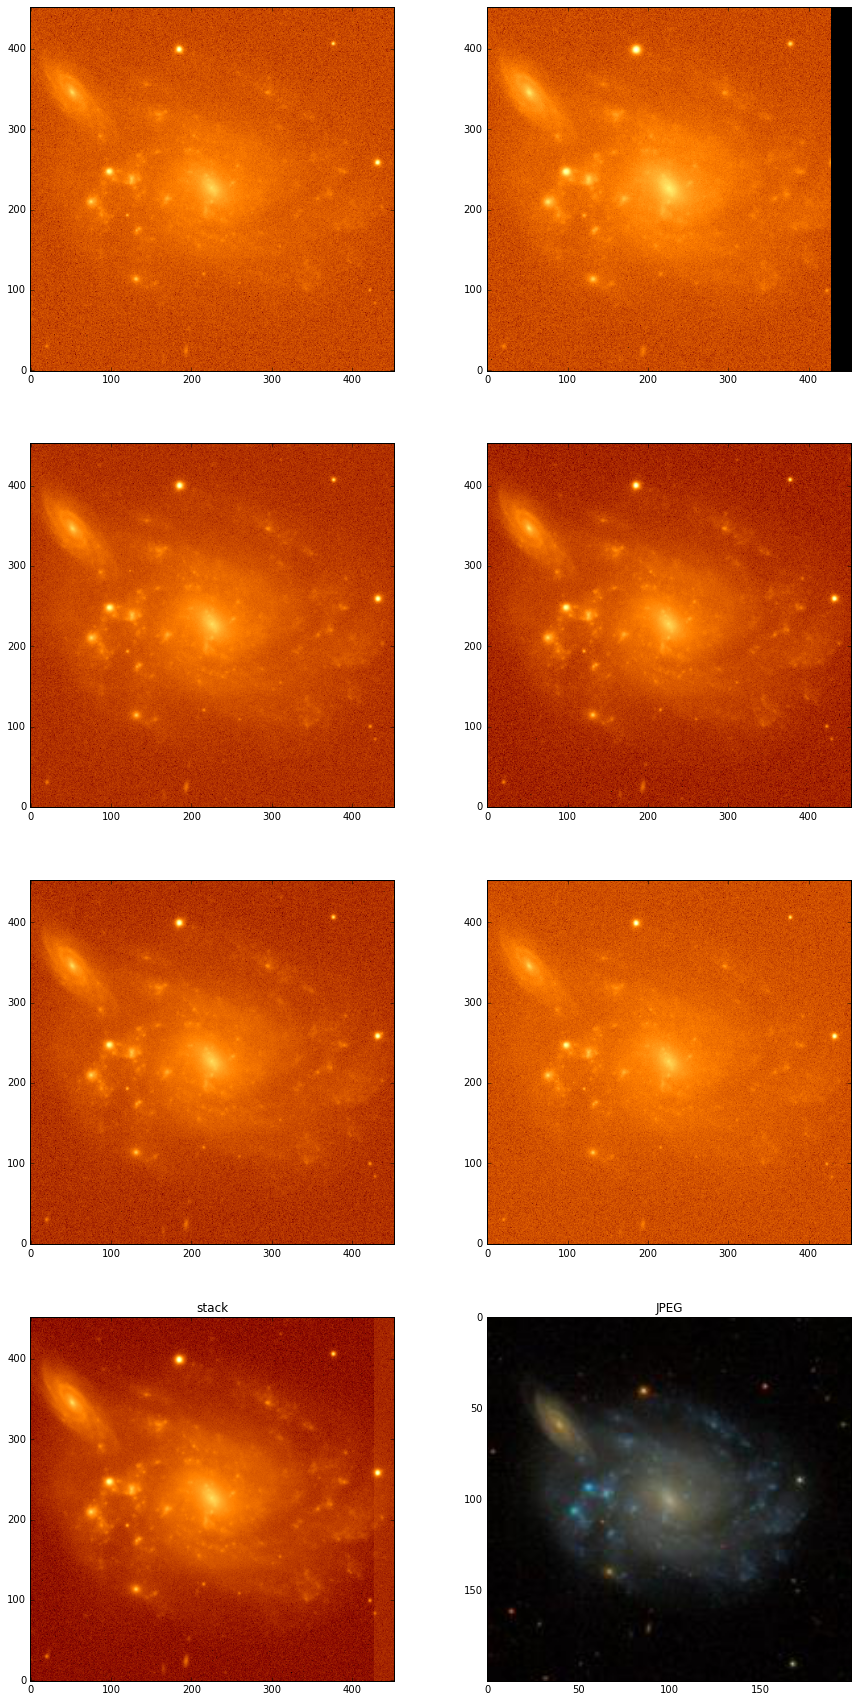

In [16]:
width=200
height=200
pixelsize=0.396
_cmap='afmhot'
#_cmap='cool'
_vmin=1000
_vmax=10000

nx=4
ny=2
nmax=nx*ny
plt.figure(figsize=(15, 15*nx/ny))
sp = 1
_min=np.inf
_max=-np.inf
for ix in range(0,nmax-2):
    if ix == 0:
        ra=obss.ra[ix]
        dec=obss.dec[ix]
        r90=obss.petror90_r[ix]
        size=2*r90/pixelsize
        scale=size/width
        url="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra="+str(ra)
        url+="&dec="+str(dec)+"&scale="""+str(scale)+"&width="+str(width)
        url+="&height="+str(height)
    fits_r=obss.fits_r[ix]
# IFF sdss_das is mounted read from file
    if os.path.isdir('../../sdss_das/'):
        fits_r=fits_r.replace('http://das.sdss.org','../../sdss_das/das2')
    fimg,_mask=cutout(fits_r,ra,dec,np.floor(size))
    if ix == 0:
        stack = np.zeros(fimg.shape, dtype=float)
        mask = np.zeros(stack.shape, dtype=float)
    stack=stack+fimg
    mask=mask+_mask
    plt.subplot(nx,ny,sp)
    
#    scimg=loggray(fimg,_mask)
    scimg=img_scale.asinh(fimg,scale_min=np.min(fimg[_mask>0]))

    im=plt.imshow(scimg,  cmap=_cmap,origin='lower')
    sp+=1
ix=np.where(mask > 0.1)
stack[ix]=stack[ix]/mask[ix]
stack[mask==0]=0
plt.subplot(nx,ny,sp)

#scimg=loggray(stack,mask)
scimg=img_scale.asinh(stack,scale_min=np.min(stack[mask>0]))
im=plt.imshow(scimg,cmap=_cmap,origin='lower')
plt.title('stack')
img=skimage.io.imread(url)
sp+=1
plt.subplot(nx,ny,sp)
plt.imshow(img)
plt.title("JPEG")


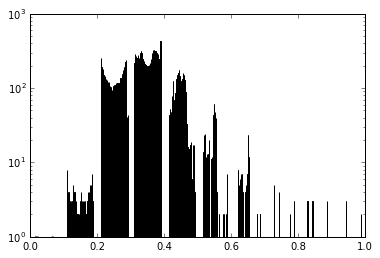

In [18]:
#histogram = plt.hist(scimg.flat, NBINS)
histogram = plt.hist(scimg)
plt.yscale('log')